`ProPublica Recidivism/COMPAS` :<br>
    The COMPAS dataset (Correctional Offender Management Profiling for Alternative Sanctions) is a dataset used for binary classification tasks in the field of criminal justice. The goal is to predict whether a defendant will re-offend within two years of release, based on various demographic and criminal history features.<br>
    Reference Link: https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative,print_recourse_report_KStest_cumulative
import matplotlib.pyplot as plt
from aif360.sklearn.datasets import fetch_compas
from facts.utils import load_rules_by_if, save_rules_by_if

from IPython.display import Markdown, display

## Load Dataset

In [12]:
from pathlib import Path

computed_rules_file = Path("..") / ".." / "Pre-computed Results" / "Compas" / "rulesCompas_atomic.data"
computed_rules_with_cumulative_file = Path("..") / ".." / "Pre-computed Results" / "Compas" / "rulesCompas_cumulative.data"

In [13]:
X, y = fetch_compas()
X['target'] = y.values

sensitive_attribute = "race"
df = clean_dataset(X,'compas')
y = df['target']
X = df.drop('target', axis=1)

X.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
0,Male,Greater than 45,Other,0,0,0,"(-0.1, 1.0]",F
1,Male,25 - 45,African-American,0,0,0,"(-0.1, 1.0]",F
2,Male,10-25,African-American,0,0,1,"(1.0, 5.0]",F
3,Male,25 - 45,Other,0,0,0,"(-0.1, 1.0]",M
4,Male,25 - 45,Caucasian,0,0,0,"(10.0, 15.0]",F


## Model training and test

In [19]:
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [20]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='target')
model.predict(X_test.iloc[:100, :])

CPU times: total: 31.2 ms
Wall time: 49 ms


array([0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.])

In [21]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       843
           1       0.69      0.75      0.72      1008

    accuracy                           0.68      1851
   macro avg       0.67      0.67      0.67      1851
weighted avg       0.67      0.68      0.67      1851



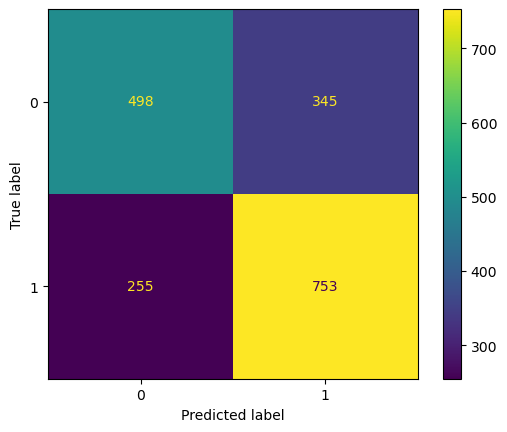

In [22]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Contribution

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [23]:
#Uncomment if you want to find new rules with different support

start_time = time.time()
ifthens_coverage_correctness, stats = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='race',
    freqitem_minsupp = 0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = False
)
end_time = time.time()

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 33.42it/s]

Number of frequent itemsets for affected: {'African-American': 1360, 'Asian': 127, 'Caucasian': 1431, 'Hispanic': 1187, 'Native American': 431, 'Other': 879}
Computing the intersection between the frequent itemsets of each subgroup of the affected instances.

100%|████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 126346.44it/s]

Number of subgroups in the intersection: 95
Number of frequent itemsets for the unaffected: 2895
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|███████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 22984.48it/s]

Computing correctenesses for all valid if-thens.



100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:03<00:00, 54.66it/s]

Number of if-thens: 188


In [24]:
stats["valid-if-thens-time"] = end_time - start_time
stats["triples-no"] = len(ifthens_coverage_correctness)
stats["subgroup-no"] = len(rules_by_if)

In [9]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if(computed_rules_file)

## Use this for saving rules on disk
#save_rules_by_if(precomputed_rules_file, rules_by_if)

In [11]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Caucasian"][1][0][1]-e[1]["African-American"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 1.03% covered
		Make age_cat = 25 - 45, c_charge_degree = M, juv_misd_count = 0 with correctness 0.00%.
		Make age_cat = 25 - 45, juv_misd_count = 0 with correctness 0.00%.
		Make age_cat = Greater than 45, juv_misd_count = 0 with correctness 50.00%.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_misd_count = 0 with correctness 50.00%.
		Make c_charge_degree = M, juv_misd_count = 0 with correctness 0.00%.
	Protected Subgroup 'African-American', 2.71% covered
		Make age_cat = 25 - 45, c_charge_degree = M, juv_misd_count = 0 with correctness 85.71%.
		Make age_cat = 25 - 45, juv_misd_count = 0 with correctness 42.86%.
		Make age_cat = Greater than 45, juv_misd_count = 0 with correctness 92.86%.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_misd_count = 0 with correctness 92.86%.
		Make c_charge_degree = M, juv_misd_count = 0 with correctnes

## Macro Viewpoint

In [35]:
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = []
feature_weights = {'sex':100,	'age_cat':10,	'race':100,	'juv_fel_count':1,	'juv_fel_count':1,	'juv_other_count':1,	'priors_count':1,	'c_charge_degree':1}

features_with_binary_cost = cate_features
features_with_proportional_cost = num_features

Xcopy = X.copy()
Xcopy = Xcopy.astype({"age_cat": "object", "race": "object", "c_charge_degree": "object"})
comparators = facts.feature_change_builder(
    Xcopy,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=False,
    #feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

### Equal Cost of Effectiveness (Macro)

In [60]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If age_cat = 25 - 45, juv_fel_count = 0, juv_misd_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 31
		Make age_cat = Greater than 45 with correctness 100.00%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 41.44% covered out of 3173
		Make age_cat = Greater than 45 with correctness 51.56%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Caucasian', 50.94% covered out of 2100
		Make age_cat = Greater than 45 with correctness 58.02%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Hispanic', 43.48% covered out of 509
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'Native American', 60.00% covered out of 11
		Make age_cat = Greater than 45 with correctness 66.67%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Other', 59.09% covered out of 343
		Make age_cat = Greater than 45 with correctness 76.92%.
		Aggrega

### Equal Choice for Recourse

In [61]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If age_cat = 25 - 45, c_charge_degree = M, juv_fel_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 31
		Make age_cat = Greater than 45, c_charge_degree = F with correctness 100.00%.
		Make age_cat = Greater than 45 with correctness 100.00%.
		Aggregate cost of the above recourses = -2.00
	Protected Subgroup 'African-American', 12.52% covered out of 3173
		Make age_cat = Greater than 45, c_charge_degree = F with correctness 60.29%.
		Make age_cat = Greater than 45 with correctness 60.29%.
		Aggregate cost of the above recourses = -2.00
	Protected Subgroup 'Caucasian', 6.29% covered out of 2100
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'Hispanic', 8.70% covered out of 509
		Make age_cat = Greater than 45 with correctness 50.00%.
		Aggregate cost of the above recourses = -1.00
	Protected Subgroup 'Native American', 20.00% covered out of 11
		Make age_cat = Greater than 45, c_charge_degree = F with correc

## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [62]:
# start_time = time.time()
# rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="race", params=params)
# end_time = time.time()

In [63]:
# stats["cumulative-time"] = end_time - start_time

In [64]:
## Use this for loading rules from disk
# rules_with_cumulative = load_rules_by_if(computed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(computed_rules_with_cumulative_file, rules_with_cumulative)

# facts.update_costs_cumulative(rules_with_cumulative, params)

### Equal (Conditional) Mean Recourse

If age_cat = 25 - 45, juv_fel_count = 0, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 43.28% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 47.66% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 48.43% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 58.44% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Hispanic', 34.78% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 12.50% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Native American', 60.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 66.67% and counter

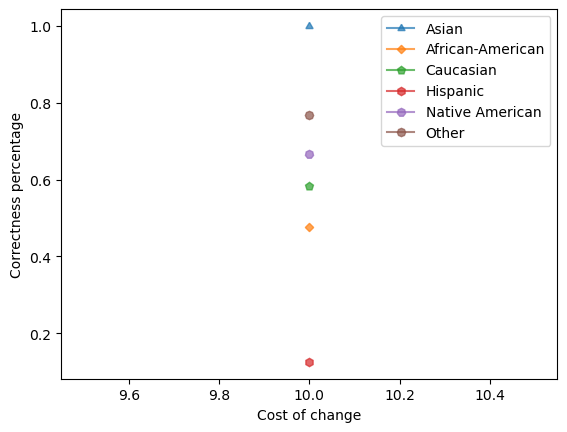

If age_cat = 25 - 45, c_charge_degree = M, juv_other_count = 0:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = F with effectiveness 100.00% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 12.34% covered out of 543
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 65.67% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = F with effectiveness 65.67% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 5.66% covered out of 159
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Mak

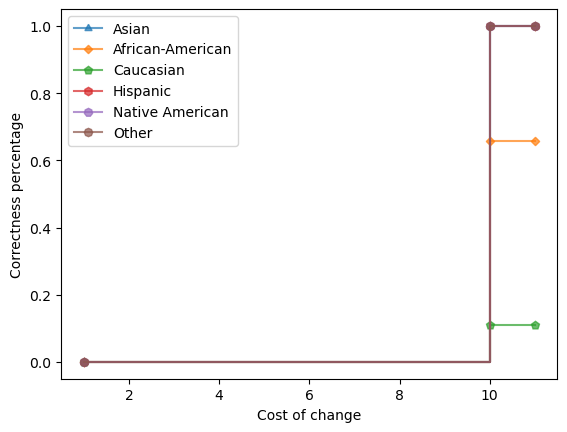

If age_cat = 25 - 45, juv_fel_count = 0, juv_misd_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 41.44% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 51.56% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 50.94% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 58.02% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Hispanic', 43.48% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 10.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Native American', 60.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 66.67% and counterf

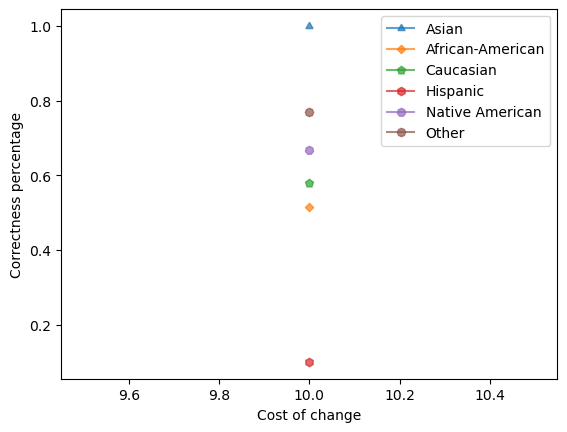

If age_cat = 25 - 45, juv_fel_count = 0, juv_misd_count = 0, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Make age_cat = Greater than 45, priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 16.21% covered out of 543
		Make priors_count = (1.0, 5.0] with effectiveness 9.09% and counterfactual cost = 1.0.
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Make age_cat = Grea

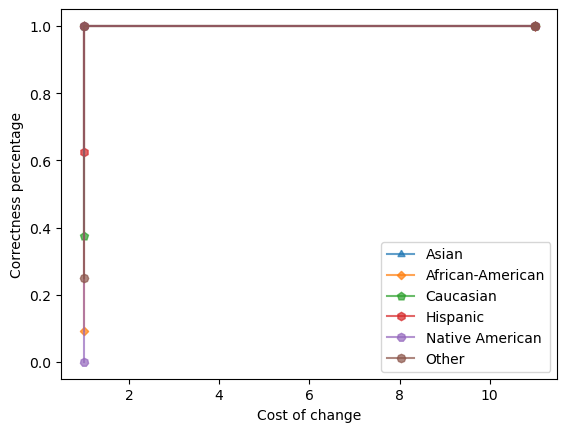

If age_cat = 25 - 45, juv_fel_count = 0, juv_other_count = 0, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Make age_cat = Greater than 45, priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 17.50% covered out of 543
		Make priors_count = (1.0, 5.0] with effectiveness 10.53% and counterfactual cost = 1.0.
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Make age_cat = Gr

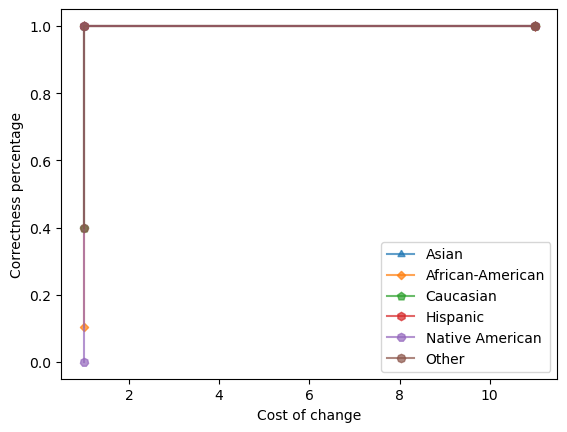

If age_cat = 25 - 45, juv_misd_count = 0, juv_other_count = 0, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Make age_cat = Greater than 45, priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 15.29% covered out of 543
		Make priors_count = (1.0, 5.0] with effectiveness 8.43% and counterfactual cost = 1.0.
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Make age_cat = Gr

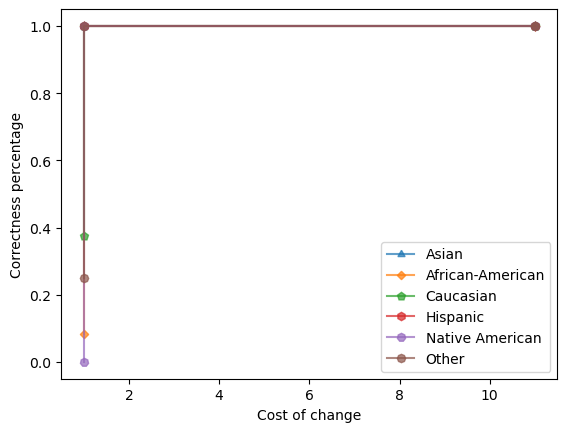

If juv_fel_count = 0, juv_misd_count = 0, juv_other_count = 0, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make juv_other_count = 1, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 17.86% covered out of 543
		Make priors_count = (1.0, 5.0] with effectiveness 23.71% and counterfactual cost = 1.0.
		Make priors_count = (-0.1, 1.0] with effectiveness 97.94% and counterfactual cost = 1.0.
		Make juv_other_count = 1, priors_count = (-0.1, 1.0] with effectiveness 97.94% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Caucasian', 28.93% covered out of 159
		Make priors_count = (1.0, 5.0] with effective

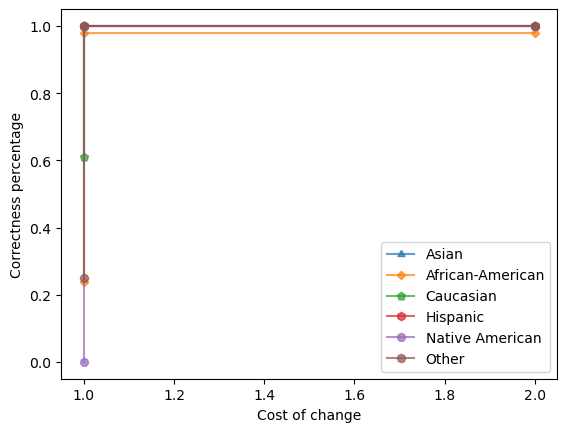

In [65]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness

If age_cat = 25 - 45, c_charge_degree = M, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = F with effectiveness 100.00% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 11.97% covered out of 543
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 64.62% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = F with effectiveness 64.62% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 0.65
	Protected Subgroup 'Caucasian', 4.40% covered out of 159
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 

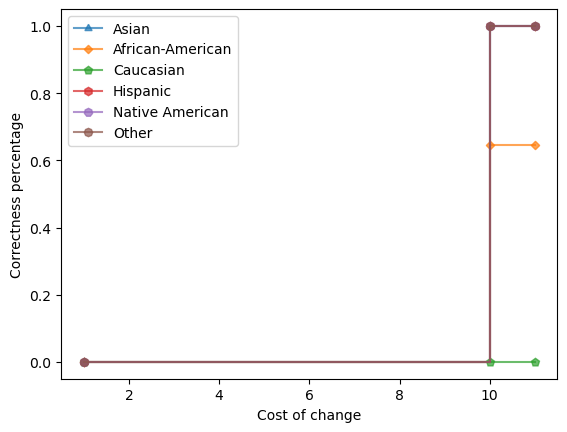

If age_cat = 25 - 45, juv_misd_count = 0:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 46.59% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 50.99% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.51
	Protected Subgroup 'Caucasian', 57.86% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 59.78% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.60
	Protected Subgroup 'Hispanic', 47.83% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 9.09% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.09
	Protected Subgroup 'Native American', 80.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 75.00% and counterfactual cost = 10.0.
		Aggregate cost

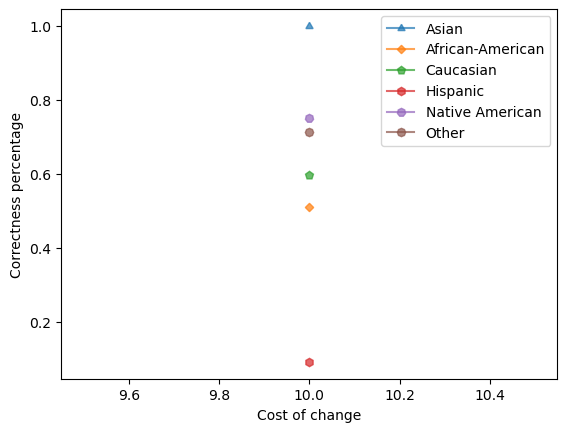

If age_cat = 25 - 45, juv_other_count = 0:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 49.91% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 46.13% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.46
	Protected Subgroup 'Caucasian', 55.35% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 60.23% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.60
	Protected Subgroup 'Hispanic', 34.78% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 12.50% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.12
	Protected Subgroup 'Native American', 80.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 75.00% and counterfactual cost = 10.0.
		Aggregate co

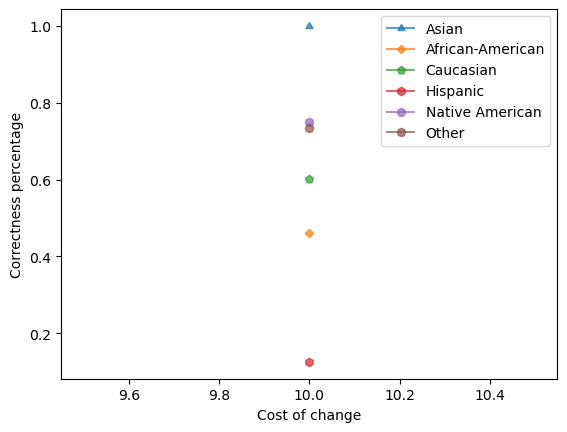

If priors_count = (5.0, 10.0], sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 23.20% covered out of 543
		Make priors_count = (1.0, 5.0] with effectiveness 14.29% and counterfactual cost = 1.0.
		Make priors_count = (-0.1, 1.0] with effectiveness 96.03% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.96
	Protected Subgroup 'Caucasian', 28.93% covered out of 159
		Make priors_count = (1.0, 5.0] with effectiveness 45.65% and counterfactual cost = 1.0.
		Make priors_count = (-0.1, 1.0] with effectiveness 95.65% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.96
	Protected Subgroup 'Hispanic', 34.78% covered out of 23
		Make priors_count = (1.0, 5.0] wi

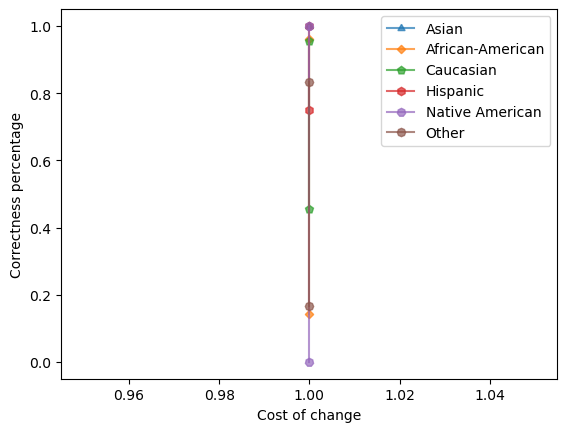

If c_charge_degree = M, juv_fel_count = 0, juv_misd_count = 0, juv_other_count = 0:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'African-American', 13.44% covered out of 543
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'Caucasian', 12.58% covered out of 159
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'Hispanic', 8.70% covered out of 23
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'Native American', 20.00% covered out of 5
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cos

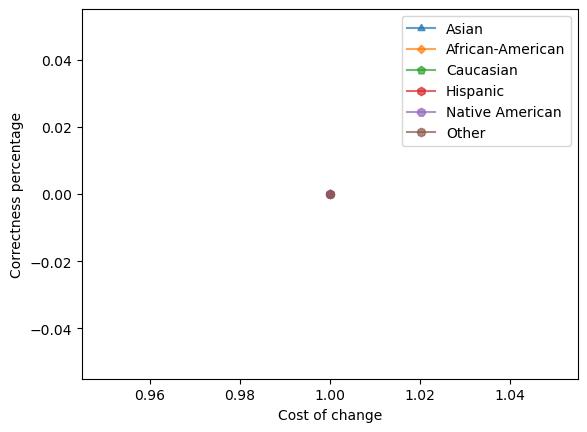

If age_cat = 25 - 45, juv_fel_count = 0, juv_misd_count = 0, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Make age_cat = Greater than 45, priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 16.21% covered out of 543
		Make priors_count = (1.0, 5.0] with effectiveness 9.09% and counterfactual cost = 1.0.
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.0.
		Make age_cat = Grea

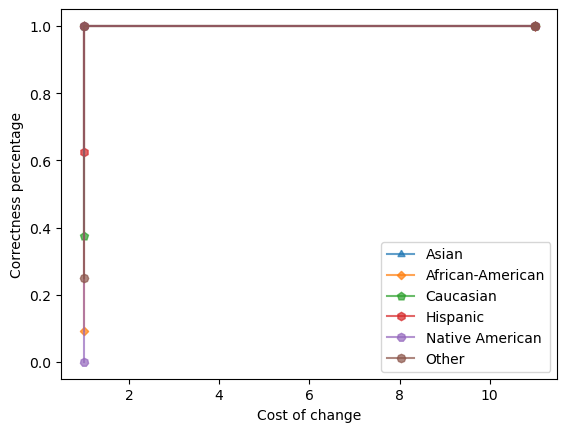

In [66]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

If age_cat = 25 - 45, juv_fel_count = 0, juv_misd_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 41.44% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 51.56% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 50.94% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 58.02% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Hispanic', 43.48% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 10.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'Native American', 60.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 66.67% and counterfac

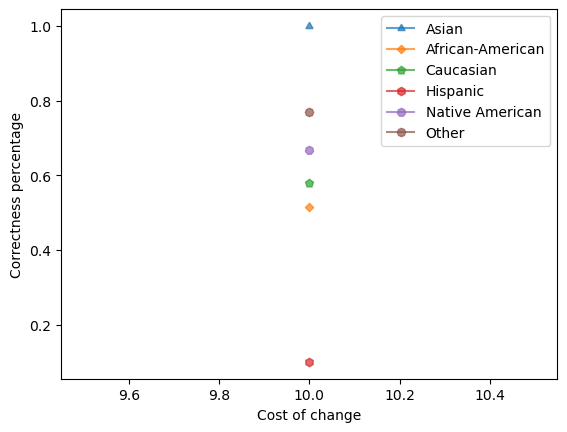

If age_cat = 25 - 45, c_charge_degree = M, juv_fel_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 12.52% covered out of 543
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 60.29% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 6.29% covered out of 159
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 20.00% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = F with effectiveness 20.00% and counterfactual cost = 11.0.
		Aggregate cost 

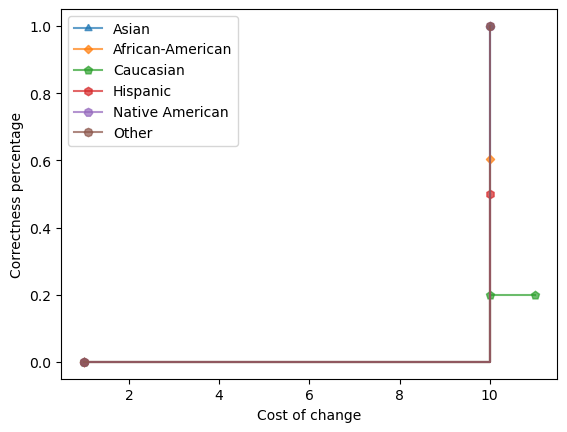

If age_cat = 25 - 45, c_charge_degree = M, juv_misd_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 12.34% covered out of 543
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 61.19% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 6.29% covered out of 159
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 20.00% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = F with effectiveness 20.00% and counterfactual cost = 11.0.
		Aggregate cost

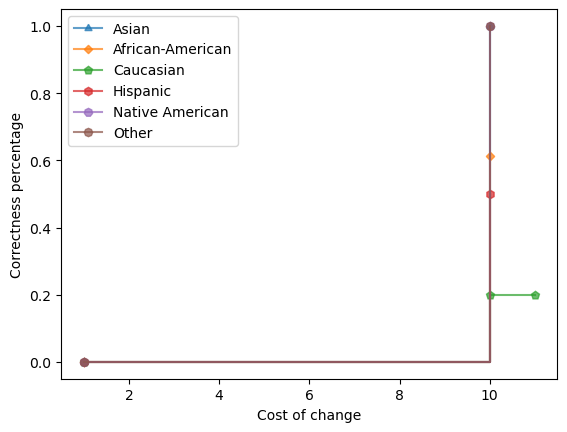

If age_cat = 25 - 45, c_charge_degree = M, juv_misd_count = 0, juv_other_count = 0:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 11.60% covered out of 543
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 68.25% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 5.66% covered out of 159
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 11.11% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = F with effectiveness 11.11% and counterfactual cost = 11.0.
		Aggre

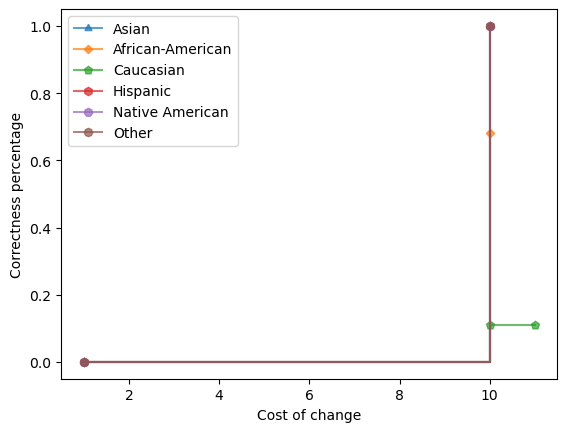

If age_cat = 25 - 45, c_charge_degree = M, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 11.97% covered out of 543
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 64.62% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 4.40% covered out of 159
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 0.00% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 11.0.
		Aggregate cost 

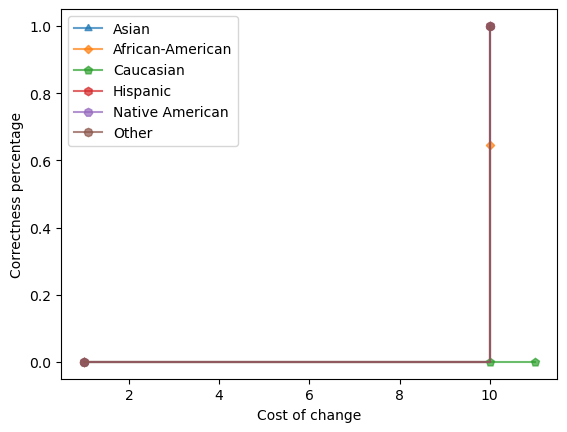

If age_cat = 25 - 45, juv_fel_count = 0, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 43.28% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 47.66% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 48.43% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 58.44% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Hispanic', 34.78% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 12.50% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'Native American', 60.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 66.67% and counterfa

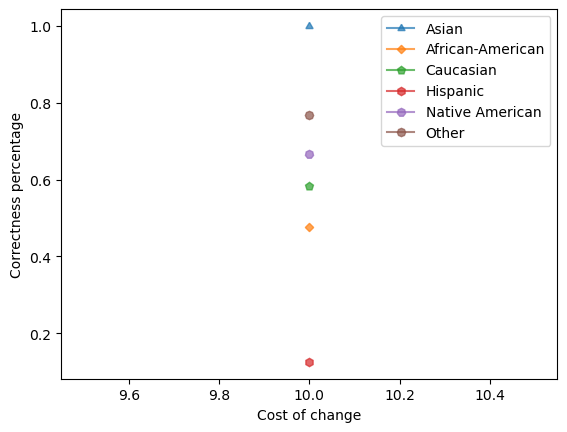

If age_cat = 25 - 45, juv_misd_count = 0, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 40.88% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 50.90% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 48.43% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 58.44% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Hispanic', 26.09% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 16.67% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'Native American', 60.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 66.67% and counterf

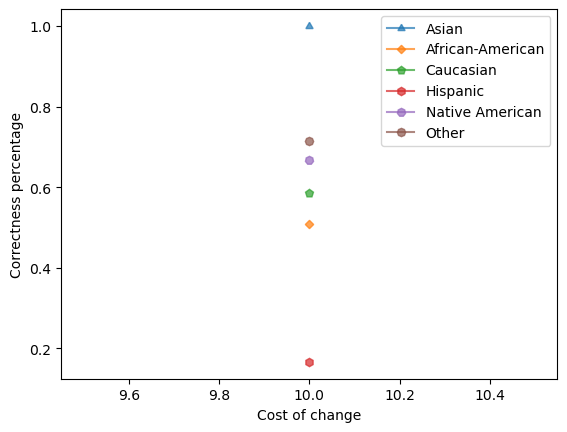

If age_cat = 25 - 45, juv_fel_count = 0, juv_misd_count = 0, juv_other_count = 0:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 39.41% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 54.21% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 52.83% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 63.10% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Hispanic', 26.09% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 16.67% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'Native American', 80.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 75.00% and c

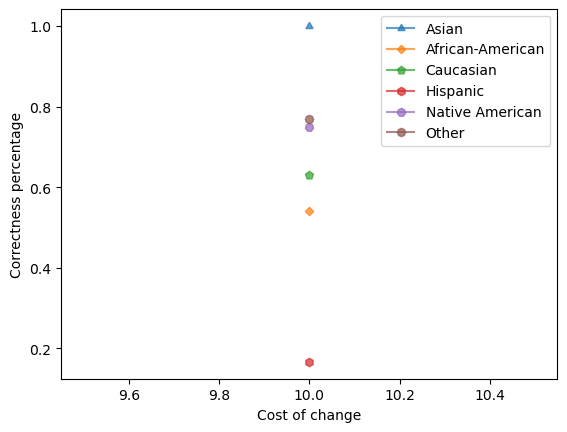

If age_cat = 25 - 45, c_charge_degree = M, juv_fel_count = 0, juv_other_count = 0:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'African-American', 11.60% covered out of 543
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 68.25% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Caucasian', 5.66% covered out of 159
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 11.11% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = F with effectiveness 11.11% and counterfactual cost = 11.0.
		Aggreg

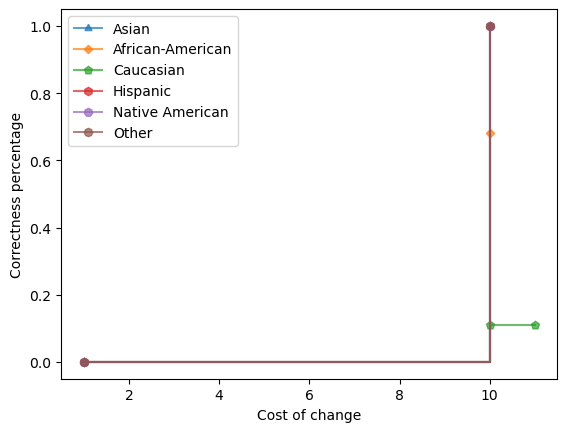

In [67]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

If age_cat = 25 - 45, c_charge_degree = M, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 11.97% covered out of 543
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 64.62% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.65
	Protected Subgroup 'Caucasian', 4.40% covered out of 159
		Make c_charge_degree = F with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 0.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'Hispanic', 4.35% covered out of 23
		Make c_charge_degree = F 

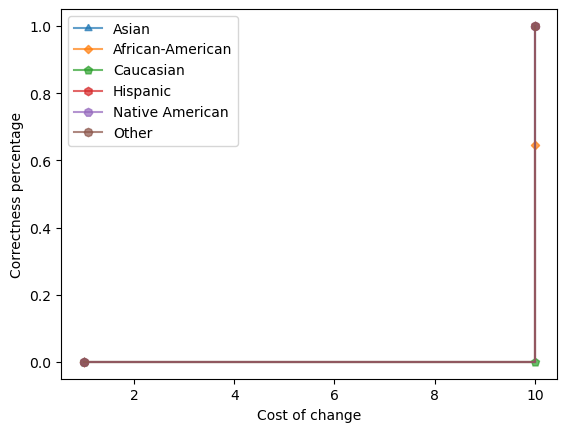

If age_cat = 25 - 45, juv_misd_count = 0:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 46.59% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 50.99% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.51
	Protected Subgroup 'Caucasian', 57.86% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 59.78% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.60
	Protected Subgroup 'Hispanic', 47.83% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 9.09% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.09
	Protected Subgroup 'Native American', 80.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 75.00% and counterfactual cost = 10.0.
		Aggregate cost

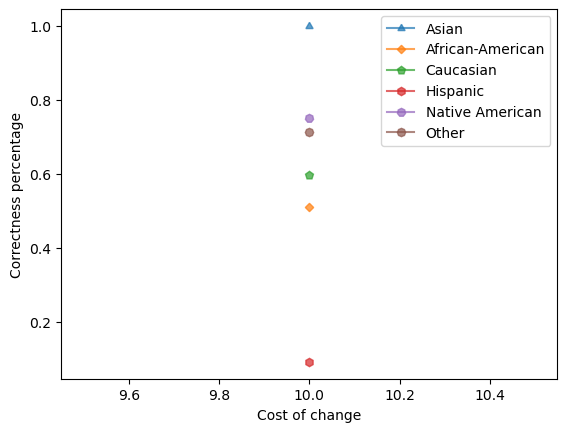

If age_cat = 25 - 45, juv_other_count = 0:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 49.91% covered out of 543
		Make age_cat = Greater than 45 with effectiveness 46.13% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.46
	Protected Subgroup 'Caucasian', 55.35% covered out of 159
		Make age_cat = Greater than 45 with effectiveness 60.23% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.60
	Protected Subgroup 'Hispanic', 34.78% covered out of 23
		Make age_cat = Greater than 45 with effectiveness 12.50% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.12
	Protected Subgroup 'Native American', 80.00% covered out of 5
		Make age_cat = Greater than 45 with effectiveness 75.00% and counterfactual cost = 10.0.
		Aggregate co

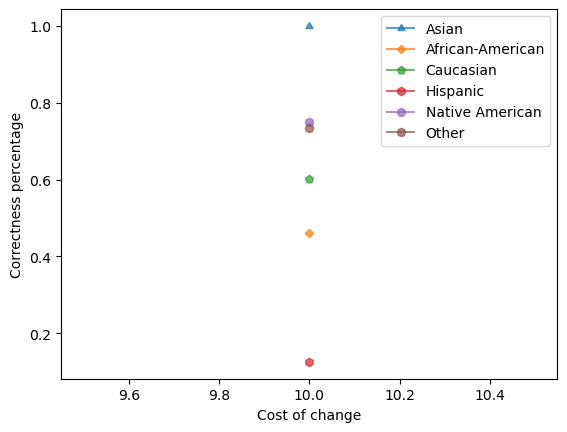

If priors_count = (5.0, 10.0], sex = Male:
	Protected Subgroup 'Asian', 100.00% covered out of 1
		Make priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 23.20% covered out of 543
		Make priors_count = (1.0, 5.0] with effectiveness 14.29% and counterfactual cost = 1.0.
		Make priors_count = (-0.1, 1.0] with effectiveness 96.03% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.96
	Protected Subgroup 'Caucasian', 28.93% covered out of 159
		Make priors_count = (1.0, 5.0] with effectiveness 45.65% and counterfactual cost = 1.0.
		Make priors_count = (-0.1, 1.0] with effectiveness 95.65% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.96
	Protected Subgroup 'Hispanic', 34.78% covered out of 23
		Make priors_count = (1.0, 5.0] wi

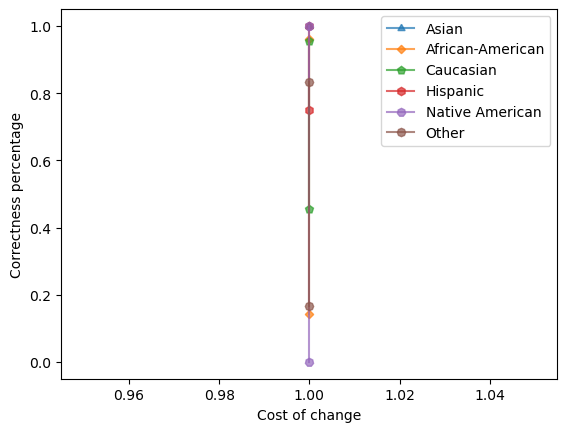

In [68]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

In [69]:
# affected_pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}

# top_rules,unfairness = facts.select_rules_subset_KStest(
#     rules_with_cumulative,
#     affected_pop_sizes,
#     top_count=50
# )

# print_recourse_report_KStest_cumulative(
#     top_rules,
#     population_sizes=pop_sizes,
#     unfairness = unfairness,
#     show_then_costs=True,
#     show_cumulative_plots=True
# )

In [70]:
end_time = time.time()

In [71]:
end_time - start_time

4.847071886062622

In [72]:
stats["metrics-time"] = end_time - start_time

In [73]:
stats

{'freq-itemsets-no': {'African-American': 1360,
  'Asian': 127,
  'Caucasian': 1431,
  'Hispanic': 1187,
  'Native American': 431,
  'Other': 879},
 'inter-groups-no': 95,
 'unaff-freq-itemsets-no': 2895,
 'valid-if-thens-time': 3.7144041061401367,
 'triples-no': 188,
 'subgroup-no': 88,
 'cumulative-time': 2.577716112136841,
 'metrics-time': 4.847071886062622}

In [74]:
stats["valid-if-thens-time"] + stats["cumulative-time"] + stats["metrics-time"]

11.1391921043396

In [79]:
np.sum(list(stats["freq-itemsets-no"].values())) - 1431

3984